In [1]:
# Version Check
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
import pandas as pd
import numpy as np
import scipy
print("python", sys.version)
print("tensorflow", tf.__version__)
print("tensorflow-datasets", tfds.__version__)
print("Pillow", PIL.__version__)
print("pandas", pd.__version__)
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print()
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
tensorflow 2.6.2
tensorflow-datasets 4.4.0
Pillow 8.3.2
pandas 1.3.3
numpy 1.19.5
scipy 1.7.1

Num GPUs Available: 1
Built with CUDA: True
Built with GPU support: True


## ImageDataGenerator

In [2]:
# Data Prep

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt

train_dir = 'dataset/archive/training_set'
valid_dir = 'dataset/archive/test_set'

In [3]:
# ImageDataGenerator (without augmentation)
image_gen = ImageDataGenerator(rescale=1/255.)

# flow_from_directory
train_gen = image_gen.flow_from_directory(train_dir, 
                                          batch_size=32, 
                                          target_size=(224, 224), 
                                          classes=['cats', 'dogs'], 
                                          class_mode='binary', 
                                          seed=2022)

valid_gen = image_gen.flow_from_directory(valid_dir, 
                                          batch_size=32, 
                                          target_size=(224, 224), 
                                          classes=['cats', 'dogs'], 
                                          class_mode='binary', 
                                          seed=2022)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [4]:
# train_gen

In [5]:
# next(train_gen)

In [6]:
len(next(train_gen)[0]), len(next(train_gen)[1])

(32, 32)

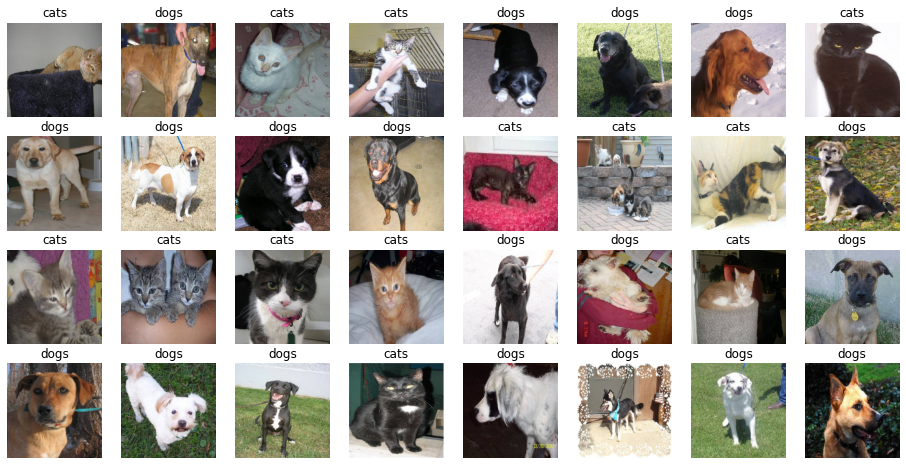

In [7]:
# Display sample images in one batch

class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))

for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis('off')

# plt.tight_layout()
plt.show()

## Model / Compile / Fit / Evaluate

In [8]:
# Sequential API

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model():
    
    model = Sequential([
        
        # Convolution
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Classifier (Output)
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid'),
    ])
    
    return model

model = build_model()

In [9]:
# Compile

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
              metrics=['acc'])

In [10]:
# Fit

history = model.fit(train_gen, 
                    validation_data=valid_gen, 
                    epochs=20)

Epoch 1/20


C:\Users\hawoo\anaconda3\envs\tf_cert\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


251/251 [==============================] - 15s 55ms/step - loss: 2.4930 - acc: 0.5704 - val_loss: 0.6552 - val_acc: 0.6134
Epoch 2/20
251/251 [==============================] - 13s 53ms/step - loss: 0.6397 - acc: 0.6215 - val_loss: 0.6479 - val_acc: 0.6164
Epoch 3/20
251/251 [==============================] - 14s 55ms/step - loss: 0.6161 - acc: 0.6451 - val_loss: 0.5606 - val_acc: 0.7084
Epoch 4/20
251/251 [==============================] - 13s 54ms/step - loss: 0.5981 - acc: 0.6475 - val_loss: 0.5842 - val_acc: 0.6594
Epoch 5/20
251/251 [==============================] - 13s 53ms/step - loss: 0.5844 - acc: 0.6663 - val_loss: 0.5475 - val_acc: 0.7093
Epoch 6/20
251/251 [==============================] - 13s 52ms/step - loss: 0.5774 - acc: 0.6823 - val_loss: 0.5562 - val_acc: 0.7217
Epoch 7/20
251/251 [==============================] - 14s 55ms/step - loss: 0.5568 - acc: 0.6887 - val_loss: 0.5523 - val_acc: 0.7108
Epoch 8/20
251/251 [==============================] - 14s 54ms/step - los

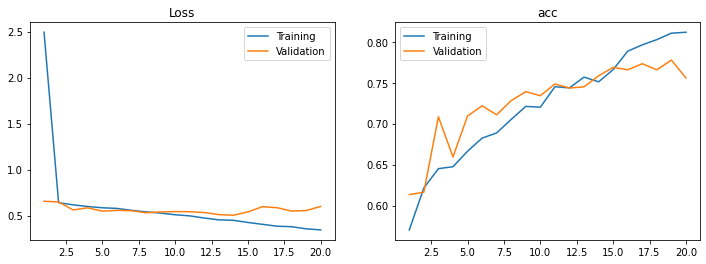

In [11]:
# Plot loss and acc
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('acc')

    plt.show()

plot_loss_acc(history, 20)

## ImageDataGenerator (with augmentation)

In [15]:
# ImageDataGenerator (with augmentation)
image_gen_aug = ImageDataGenerator(rescale=1/255., 
                                   horizontal_flip=True, 
                                   rotation_range=35, 
                                   zoom_range=0.2)

# flow_from_directory
train_gen_aug = image_gen.flow_from_directory(train_dir, 
                                              batch_size=32, 
                                              target_size=(224, 224), 
                                              classes=['cats', 'dogs'], 
                                              class_mode='binary', 
                                              seed=2022)

valid_gen_aug = image_gen.flow_from_directory(valid_dir, 
                                              batch_size=32, 
                                              target_size=(224, 224), 
                                              classes=['cats', 'dogs'], 
                                              class_mode='binary', 
                                              seed=2022)

# Model
model_aug = build_model()

# Compile
model_aug.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
                  metrics=['acc'])

# Fit
history_aug = model_aug.fit(train_gen, 
                            validation_data=valid_gen, 
                            epochs=40)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/40
251/251 [==============================] - 14s 53ms/step - loss: 2.0482 - acc: 0.5933 - val_loss: 0.6717 - val_acc: 0.5783
Epoch 2/40
251/251 [==============================] - 13s 52ms/step - loss: 0.6241 - acc: 0.6397 - val_loss: 0.6191 - val_acc: 0.6288
Epoch 3/40
251/251 [==============================] - 13s 52ms/step - loss: 0.6072 - acc: 0.6571 - val_loss: 0.5625 - val_acc: 0.6891
Epoch 4/40
251/251 [==============================] - 13s 52ms/step - loss: 0.5830 - acc: 0.6814 - val_loss: 0.5603 - val_acc: 0.7098
Epoch 5/40
251/251 [==============================] - 13s 52ms/step - loss: 0.5661 - acc: 0.6946 - val_loss: 0.5695 - val_acc: 0.7158
Epoch 6/40
251/251 [==============================] - 13s 52ms/step - loss: 0.5415 - acc: 0.7083 - val_loss: 0.5486 - val_acc: 0.7143
Epoch 7/40
251/251 [==============================] - 13s 52ms/step - loss: 0.5362 - acc: 0.7194 - val_loss: 0.5

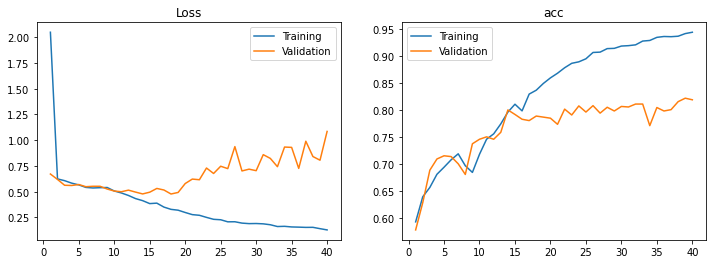

In [16]:
# Plot loss and acc
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('acc')

    plt.show()

plot_loss_acc(history_aug, 40)

# The model has not improvied with data augmentation & increased epochs.